# XGBRegression (LMA features to P,A,D coordinates)

In [1]:
# Current best:
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 11, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.05, 'alpha': 0.25}

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
from mpl_toolkits import mplot3d

## Load Data

In [2]:
dataset = pd.read_csv('datasets/S_BANDAI_5frame.csv')
print(dataset.shape)

(78551, 28)


### Split into Test and Train data

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 62841
No Test Samples: 15710


### Split Features from Targets

In [4]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [5]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
63845,-1.331408,-0.552679,-1.427279,-1.309027,-0.030897,-0.338613,-1.031785,-0.986983,-0.651365,-0.489418,...,1.035419,0.160603,0.249535,1.079707,0.610102,-0.816962,-0.627034,-0.539255,-0.179265,-0.527476
11677,-1.479869,-1.054515,-1.653717,-0.949661,-0.375695,-0.495434,-1.309857,-1.108416,-0.337813,0.733087,...,0.569688,0.877449,0.907392,0.414893,0.832940,-0.710690,-0.486595,-0.360242,-0.505820,-0.582633
9342,-0.262426,-0.334198,-0.188452,0.785680,-0.849425,-0.703808,-2.031648,0.497999,0.054418,-0.133145,...,-0.825191,-0.673953,-1.372477,0.245244,-0.959866,0.923591,0.514493,1.365769,0.764715,1.177206
2099,0.788368,0.590245,-0.063850,0.788544,0.457969,0.466524,0.864615,1.042853,-2.171610,0.461663,...,-2.546093,0.376527,-0.110844,-2.832507,-1.423882,1.599165,2.102557,0.632877,-0.019156,-0.105942
69194,0.226072,0.108903,-0.390789,-1.324704,0.917296,0.337215,0.440204,-0.052022,1.513133,0.197261,...,1.322387,-0.017175,-0.053269,1.035843,0.760318,-0.709945,-0.475727,-0.407205,-0.792984,-0.523807


In [6]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
63845,0.05,-0.05,0.00
11677,-0.10,-0.60,-0.15
9342,0.30,0.40,0.60
2099,0.10,0.60,0.40
69194,0.05,-0.05,0.00


In [7]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,-0.002797,0.999650
avg_l_hand_hip_distance,0.001174,1.000542
avg_r_hand_hip_distance,-0.001272,0.998894
max_stride_length,-0.001829,0.999228
avg_l_hand_chest_distance,-0.002029,1.000883
avg_r_hand_chest_distance,-0.003010,1.002036
avg_l_elbow_hip_distance,-0.000239,0.998970
avg_r_elbow_hip_distance,0.000372,1.000448
avg_chest_pelvis_distance,-0.001018,0.993583
avg_neck_chest_distance,-0.000657,0.999284


## Define Model

In [45]:
xgbr = xgb.XGBRegressor(verbosity=1) 

params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

#{'colsample_bytree': 0.75, 'gamma': 0, 'max_depth': 15, 'min_child_weight': 5, subsample': 1, 
#'lambda': 1.25, 'eta': 0.01, 'alpha': 0.0}
model_p = xgb.XGBRegressor(
                    n_estimators=5000, learning_rate=0.05, max_depth=15, min_child_weight=5, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )


#{'colsample_bytree': 0.75, 'gamma': 0.001, 'max_depth': 15, 'min_child_weight': 11, 'subsample': 0.75, 
#'lambda': 1, 'eta': 0.01, 'alpha': 0.25}
model_a = xgb.XGBRegressor(
                    n_estimators=5000, learning_rate=0.05, max_depth=15, min_child_weight=11, 
                    reg_alpha=0.25, reg_lambda=1.0, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
        
    
#{'colsample_bytree': 0.75, 'gamma': 0, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.75, '
#'lambda': 1, 'eta': 0.05, 'alpha': 0.25}
model_d = xgb.XGBRegressor(
                    n_estimators=5000, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.25, reg_lambda=1.0, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

## Train Model

### Pleasure Regression

In [46]:
model_p.fit(train_X, train_y_p)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.0, reg_lambda=1.25,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Arousal Regression

In [47]:
model_a.fit(train_X, train_y_a)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=11, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.25, reg_lambda=1.0,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Dominance Regression

In [48]:
model_d.fit(train_X, train_y_d)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.25, reg_lambda=1.0,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

## Test Model

### Training Score

In [49]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

score = model_d.score(train_X, train_y_d)  

print()

print("Dominance")
print("Training score: ", score)

Pleasure
Training score:  0.9999962801988641

Arousal
Training score:  0.9999409794007486

Dominance
Training score:  0.9997776183430506


### Test Set MAE & MSE

In [8]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.4f" % mse)
print("MAE: %.4f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.4f" % mse)
print("MAE: %.4f" % mae)


pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nDominance")
print("MSE: %.4f" % mse)
print("MAE: %.4f" % mae)

NameError: name 'model_p' is not defined

### Graphs

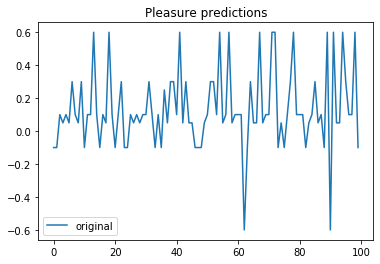

In [51]:
x_ax = range(100)
plt.plot(x_ax, test_y_p[0:100], label="original")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

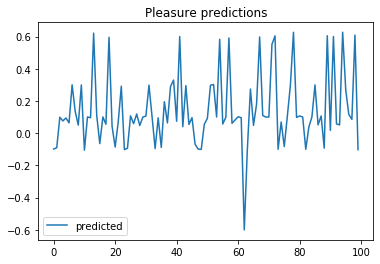

In [52]:
x_ax = range(100)
plt.plot(x_ax, pred_y_p[0:100], label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

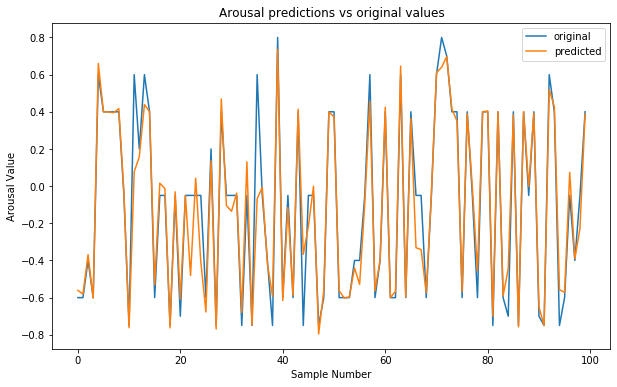

In [13]:
#x_ax = range(len(test_y_a))
x_ax = range(100)
plt.figure(figsize=(10,6))
plt.plot(x_ax, test_y_a[0:100], label="original")
plt.plot(x_ax, pred_y_a[0:100], label="predicted")

plt.title("Arousal predictions vs original values")
plt.xlabel("Sample Number")
plt.ylabel("Arousal Value")
plt.legend()
plt.show()

### Prediction Examples

In [54]:
row=test_X.iloc[1]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[1]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.1  -0.6  -0.15]
Predicted: [-0.09049491, -0.55690336, -0.15358193]


In [55]:
row=test_X.iloc[421]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[421]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [ 0.05 -0.05  0.  ]
Predicted: [0.05162171, -0.085125074, -0.02306699]


In [56]:
row=test_X.iloc[999]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[999]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [0.1 0.6 0.4]
Predicted: [0.1005157, 0.6233212, 0.42545694]


## Save Models

In [57]:
# save to JSON
model_p.save_model("models/bandai_l2p_model.json")
model_a.save_model("models/bandai_l2a_model.json")
model_d.save_model("models/bandai_l2d_model.json")

## Load Models

In [9]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("models/bandai_l2p_model.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("models/bandai_l2a_model.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("models/bandai_l2d_model.json")

### Graphs

In [10]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.00
MAE: 0.02

Arousal
MSE: 0.01
MAE: 0.06

Arousal
MSE: 0.00
MAE: 0.03


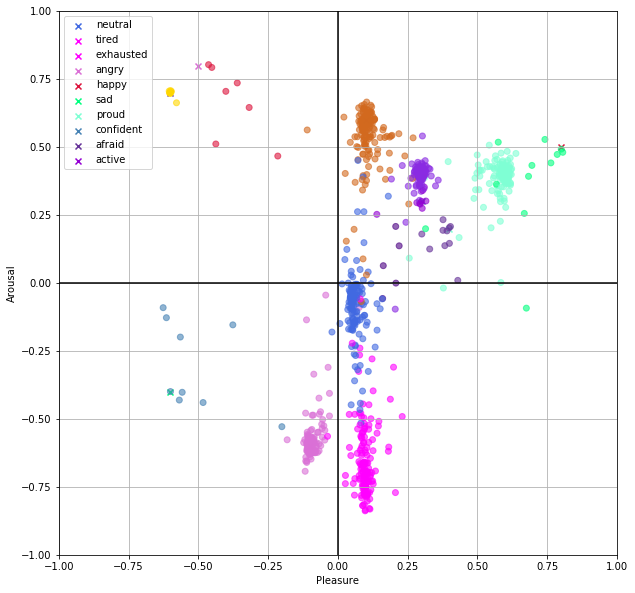

In [172]:
x = pred_y_p[0:1000]
y = pred_y_a[0:1000]
z = pred_y_d[0:1000]

x_reference = [
    ## Bandai ## 
    0.05,
    
    0.1,
    -0.1,
    
    -0.5,
    
    0.8,
    
    -0.6,
    
    0.4,
    0.3,
    
    -0.6,
    
    0.1,
]

y_reference = [
    ## Bandai ## 
    -0.05,
    
    -0.7,
    -0.6,
    
    0.8,
    
    0.5,
    
    -0.4,
    
    0.2,
    0.3,
    
    0.7,
    
    0.6,
]

z_reference = [
    ## Bandai ## 
    0.0,
    
    -0.2,
    -0.15,
    
    0.9,
    
    0.15,
    
    -0.3,
    
    0.35,
    0.9,
    
    -0.8,
    
    0.4,
]

colors_reference = ["royalblue", 
                    "fuchsia", "magenta", "orchid", 
                    "crimson", 
                    "springgreen", "aquamarine", 
                    "steelblue",
                    "rebeccapurple", "darkviolet", "indigo", "blueviolet",
                    "gold", 
                    "chocolate", 
                    
                   ]

colors = []

color_map = {
    ## Bandai ## 
    (0.05, -0.05): "royalblue", # Normal bandai 1/2
    
    (0.1, -0.7): "fuchsia", # Tired bandai 1
    (0.1, -0.75): "magenta", # Exhausted bandai 2
    (-0.1, -0.6): "orchid", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.8): "crimson", # Angry bandai 1
    
    (0.8, 0.5): "springgreen", # Happy bandai 1
    (0.6, 0.4): "aquamarine", # Youthful bandai 2
    
    (-0.6, -0.4): "steelblue", # Sad bandai 1
    
    (0.4, 0.2): "rebeccapurple", # Proud bandai 1
    (0.3, 0.3): "darkviolet", # Giant bandai 1 
    (0.25, 0.15): "indigo", # Masculine / Masculinity bandai 1
    (0.3, 0.4): "blueviolet", # Masculine bandai 2
    
    (-0.6, 0.7): "gold", # Not confident bandai 1
    
    (0.1, 0.6): "chocolate", # Active bandai 1/2
}


conv_dict = {
    (0.05, -0.05): "neutral", # Normal bandai 1/2
    
    (0.1, -0.7): "tired", # Tired bandai 1
    (0.1, -0.75): "tired_2", # Exhausted bandai 2
    (-0.1, -0.6): "exhausted", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.8): "angry", # Angry bandai 1
    
    (0.8, 0.5): "happy", # Happy bandai 1
    (0.6, 0.4): "happy_2", # Youthful bandai 2
    
    (-0.6, -0.4): "sad", # Sad bandai 1
    
    (0.4, 0.2): "proud", # Proud bandai 1
    (0.3, 0.3): "confident", # Giant bandai 1 
    (0.25, 0.15): "confident_2", # Masculine / Masculinity bandai 1
    (0.3, 0.4): "confident_3", # Masculine bandai 2
    
    (-0.6, 0.7): "afraid", # Not confident bandai 1
    
    (0.1, 0.6): "active", # Active bandai 1/2
}


for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i])
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(x_reference[i], y_reference[i], c=colors_reference[i], label=conv_dict[(x_reference[i], y_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Pleasure')
plt.ylabel('Arousal')
plt.grid(True)

plt.show()



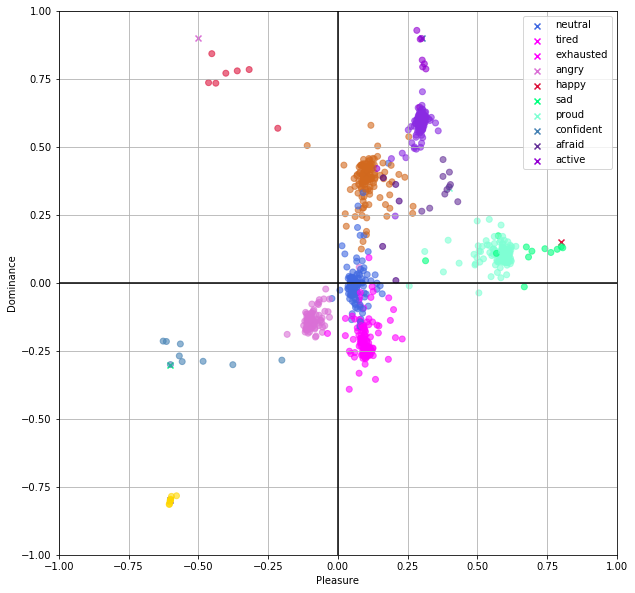

In [173]:
x = pred_y_p[0:1000]
y = pred_y_a[0:1000]
z = pred_y_d[0:1000]

x_reference = [
    ## Bandai ## 
    0.05,
    
    0.1,
    -0.1,
    
    -0.5,
    
    0.8,
    
    -0.6,
    
    0.4,
    0.3,
    
    -0.6,
    
    0.1,
]

y_reference = [
    ## Bandai ## 
    -0.05,
    
    -0.7,
    -0.6,
    
    0.8,
    
    0.5,
    
    -0.4,
    
    0.2,
    0.3,
    
    0.7,
    
    0.6,
]

z_reference = [
    ## Bandai ## 
    0.0,
    
    -0.2,
    -0.15,
    
    0.9,
    
    0.15,
    
    -0.3,
    
    0.35,
    0.9,
    
    -0.8,
    
    0.4,
]


colors_reference = ["royalblue", 
                    "fuchsia", "magenta", "orchid", 
                    "crimson", 
                    "springgreen", "aquamarine", 
                    "steelblue",
                    "rebeccapurple", "darkviolet", "indigo", "blueviolet",
                    "gold", 
                    "chocolate", 
                    
                   ]

colors = []

color_map = {
    ## Bandai ## 
    (0.05, 0.0): "royalblue", # Normal bandai 1/2
    
    (0.1, -0.2): "fuchsia", # Tired bandai 1
    (0.1, -0.25): "magenta", # Exhausted bandai 2
    (-0.1, -0.15): "orchid", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.9): "crimson", # Angry bandai 1
    
    (0.8, 0.15): "springgreen", # Happy bandai 1
    (0.6, 0.1): "aquamarine", # Youthful bandai 2
    
    (-0.6, -0.3): "steelblue", # Sad bandai 1
    
    (0.4, 0.35): "rebeccapurple", # Proud bandai 1
    (0.3, 0.9): "darkviolet", # Giant bandai 1 
    (0.25, 0.4): "indigo", # Masculine / Masculinity bandai 1
    (0.3, 0.6): "blueviolet", # Masculine bandai 2
    
    (-0.6, -0.8): "gold", # Not confident bandai 1
    
    (0.1, 0.4): "chocolate", # Active bandai 1/2
}


conv_dict = {
    ## Bandai ## 
    (0.05, 0.0): "neutral", # Normal bandai 1/2
    
    (0.1, -0.2): "tired", # Tired bandai 1
    (0.1, -0.25): "tired_2", # Exhausted bandai 2
    (-0.1, -0.15): "exhausted", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.9): "angry", # Angry bandai 1
    
    (0.8, 0.15): "happy", # Happy bandai 1
    (0.6, 0.1): "happy_2", # Youthful bandai 2
    
    (-0.6, -0.3): "sad", # Sad bandai 1
    
    (0.4, 0.35): "proud", # Proud bandai 1
    (0.3, 0.9): "confident", # Giant bandai 1 
    (0.25, 0.4): "confident_2", # Masculine / Masculinity bandai 1
    (0.3, 0.6): "confident_3", # Masculine bandai 2
    
    (-0.6, -0.8): "afraid", # Not confident bandai 1
    
    (0.1, 0.4): "active", # Active bandai 1/2
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_d.iloc[i])
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(x_reference[i], z_reference[i], c=colors_reference[i], label=conv_dict[(x_reference[i], z_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(x, z, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Pleasure')
plt.ylabel('Dominance')
plt.grid(True)

plt.show()



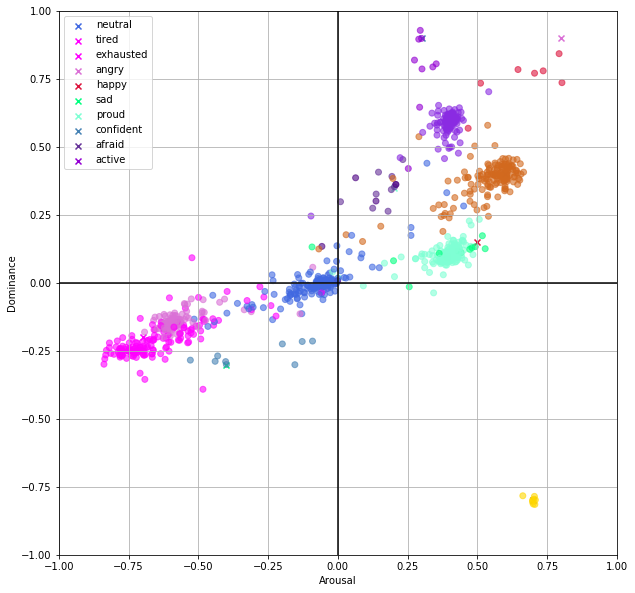

In [175]:
x = pred_y_p[0:1000]
y = pred_y_a[0:1000]
z = pred_y_d[0:1000]


x_reference = [
    ## Bandai ## 
    0.05,
    
    0.1,
    -0.1,
    
    -0.5,
    
    0.8,
    
    -0.6,
    
    0.4,
    0.3,
    
    -0.6,
    
    0.1,
]

y_reference = [
    ## Bandai ## 
    -0.05,
    
    -0.7,
    -0.6,
    
    0.8,
    
    0.5,
    
    -0.4,
    
    0.2,
    0.3,
    
    0.7,
    
    0.6,
]

z_reference = [
    ## Bandai ## 
    0.0,
    
    -0.2,
    -0.15,
    
    0.9,
    
    0.15,
    
    -0.3,
    
    0.35,
    0.9,
    
    -0.8,
    
    0.4,
]

colors_reference = ["royalblue", 
                    "fuchsia", "magenta", "orchid", 
                    "crimson", 
                    "springgreen", "aquamarine", 
                    "steelblue",
                    "rebeccapurple", "darkviolet", "indigo", "blueviolet",
                    "gold", 
                    "chocolate", 
                    
                   ]

colors = []

color_map = {
    ## Bandai ## 
    (-0.05, 0.0): "royalblue", # Normal bandai 1/2
    
    (-0.7, -0.2): "fuchsia", # Tired bandai 1
    (-0.75, -0.25): "magenta", # Exhausted bandai 2
    (-0.6, -0.15): "orchid", # Old bandai 1 & Elderly bandai 2
    
    (0.8, 0.9): "crimson", # Angry bandai 1
    
    (0.5, 0.15): "springgreen", # Happy bandai 1
    (0.4, 0.1): "aquamarine", # Youthful bandai 2
    
    (-0.4, -0.3): "steelblue", # Sad bandai 1
    
    (0.2, 0.35): "rebeccapurple", # Proud bandai 1
    (0.3, 0.9): "darkviolet", # Giant bandai 1 
    (0.15, 0.4): "indigo", # Masculine / Masculinity bandai 1
    (0.4, 0.6): "blueviolet", # Masculine bandai 2
    
    (0.7, -0.8): "gold", # Not confident bandai 1
    
    (0.6, 0.4): "chocolate", # Active bandai 1/2
}


conv_dict = {
    ## Bandai ## 
    (-0.05, 0.0): "neutral", # Normal bandai 1/2
    
    (-0.7, -0.2): "tired", # Tired bandai 1
    (-0.75, -0.25): "tired_2", # Exhausted bandai 2
    (-0.6, -0.15): "exhausted", # Old bandai 1 & Elderly bandai 2
    
    (0.8, 0.9): "angry", # Angry bandai 1
    
    (0.5, 0.15): "happy", # Happy bandai 1
    (0.4, 0.1): "happy_2", # Youthful bandai 2
    
    (-0.4, -0.3): "sad", # Sad bandai 1
    
    (0.2, 0.35): "proud", # Proud bandai 1
    (0.3, 0.9): "confident", # Giant bandai 1 
    (0.15, 0.4): "confident_2", # Masculine / Masculinity bandai 1
    (0.4, 0.6): "confident_3", # Masculine bandai 2
    
    (0.7, -0.8): "afraid", # Not confident bandai 1
    
    (0.6, 0.4): "active", # Active bandai 1/2
}


for i in range(len(x)):
    point_coords = (test_y_a.iloc[i], test_y_d.iloc[i])
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(y_reference[i], z_reference[i], c=colors_reference[i], label=conv_dict[(y_reference[i], z_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(y, z, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)

plt.show()



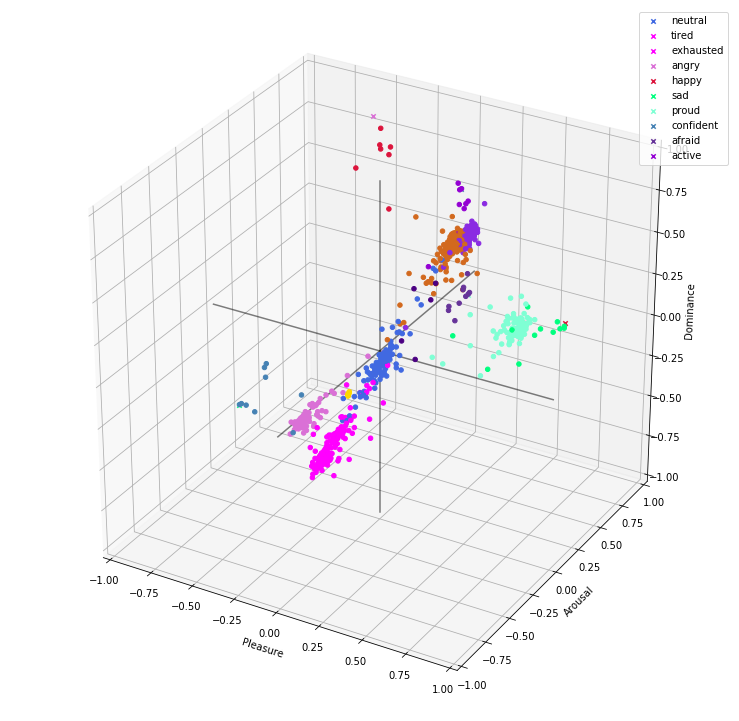

In [176]:
x = pred_y_p[0:1000]
y = pred_y_a[0:1000]
z = pred_y_d[0:1000]


x_reference = [
    ## Bandai ## 
    0.05,
    
    0.1,
    -0.1,
    
    -0.5,
    
    0.8,
    
    -0.6,
    
    0.4,
    0.3,
    
    -0.6,
    
    0.1,
]

y_reference = [
    ## Bandai ## 
    -0.05,
    
    -0.7,
    -0.6,
    
    0.8,
    
    0.5,
    
    -0.4,
    
    0.2,
    0.3,
    
    0.7,
    
    0.6,
]

z_reference = [
    ## Bandai ## 
    0.0,
    
    -0.2,
    -0.15,
    
    0.9,
    
    0.15,
    
    -0.3,
    
    0.35,
    0.9,
    
    -0.8,
    
    0.4,
]

colors_reference = ["royalblue", 
                    "fuchsia", "magenta", "orchid", 
                    "crimson", 
                    "springgreen", "aquamarine", 
                    "steelblue",
                    "rebeccapurple", "darkviolet", "indigo", "blueviolet",
                    "gold", 
                    "chocolate", 
                    
                   ]

colors = []


color_map = {
    ## Bandai ## 
    (0.05, -0.05, 0.0): "royalblue", # Normal bandai 1/2
    
    (0.1, -0.7, -0.2): "fuchsia", # Tired bandai 1
    (0.1, -0.75, -0.25): "magenta", # Exhausted bandai 2
    (-0.1, -0.6, -0.15): "orchid", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.8, 0.9): "crimson", # Angry bandai 1
    
    (0.8, 0.5, 0.15): "springgreen", # Happy bandai 1
    (0.6, 0.4, 0.1): "aquamarine", # Youthful bandai 2
    
    (-0.6, -0.4, -0.3): "steelblue", # Sad bandai 1
    
    (0.4, 0.2, 0.35): "rebeccapurple", # Proud bandai 1
    (0.3, 0.3, 0.9): "darkviolet", # Giant bandai 1 
    (0.25, 0.15, 0.4): "indigo", # Masculine / Masculinity bandai 1
    (0.3, 0.4, 0.6): "blueviolet", # Masculine bandai 2
    
    (-0.6, 0.7, -0.8): "gold", # Not confident bandai 1
    
    (0.1, 0.6, 0.4): "chocolate", # Active bandai 1/2
}


conv_dict = {
    ## Bandai ## 
    (0.05, -0.05, 0.0): "neutral", # Normal bandai 1/2
    
    (0.1, -0.7, -0.2): "tired", # Tired bandai 1
    (0.1, -0.75, -0.25): "tired_2", # Exhausted bandai 2
    (-0.1, -0.6, -0.15): "exhausted", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.8, 0.9): "angry", # Angry bandai 1
    
    (0.8, 0.5, 0.15): "happy", # Happy bandai 1
    (0.6, 0.4, 0.1): "happy_2", # Youthful bandai 2
    
    (-0.6, -0.4, -0.3): "sad", # Sad bandai 1
    
    (0.4, 0.2, 0.35): "proud", # Proud bandai 1
    (0.3, 0.3, 0.9): "confident", # Giant bandai 1 
    (0.25, 0.15, 0.4): "confident_2", # Masculine / Masculinity bandai 1
    (0.3, 0.4, 0.6): "confident_3", # Masculine bandai 2
    
    (-0.6, 0.7, -0.8): "afraid", # Not confident bandai 1
    
    (0.1, 0.6, 0.4): "active", # Active bandai 1/2
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i], test_y_d.iloc[i])
    
    colors.append(color_map[point_coords])

fig = plt.figure(figsize = (13, 13))
ax = plt.axes(projection ="3d")


for i in range(len(x_reference)):
    ax.scatter3D(x_reference[i], y_reference[i], z_reference[i], 
               c=colors_reference[i], 
               label=conv_dict[(x_reference[i], y_reference[i], z_reference[i])],
               marker="x", linewidths=10)#,s=15)

ax.legend()

ax.scatter(x, y, z, c=colors, alpha=1) #s=500)


line = mplot3d.art3d.Line3D([-1, 1], [0, 0], [0,0], color='black', alpha=0.5)
line_2 = mplot3d.art3d.Line3D([0, 0], [-1, 1], [0,0], color='black', alpha = 0.5)
line_3 = mplot3d.art3d.Line3D([0, 0], [0, 0], [-1,1], color='black', alpha = 0.5)

ax.add_line(line)
ax.add_line(line_2)
ax.add_line(line_3)


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('Pleasure')
ax.set_ylabel('Arousal')
ax.set_zlabel('Dominance')
plt.grid(True)

plt.show()



## Get LMA representatives for each emotion

In [122]:
import joblib

ds = pd.read_csv('datasets/BANDAI_5frame.csv')
scaler = joblib.load('datasets/scalers/standardizers/S_BANDAI_5frame.pkl')


ds_X = ds.copy()
ds_y = pd.concat([ds_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

scaled_ds = scaler.transform(ds_X)

emotions = {
    ## Bandai ## 
    (0.05, -0.05, 0.0): [], # Normal bandai 1/2
    
    (0.1, -0.7, -0.2): [], # Tired bandai 1
    (0.1, -0.75, -0.25): [], # Exhausted bandai 2
    (-0.1, -0.6, -0.15): [], # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.8, 0.9): [], # Angry bandai 1
    
    (0.8, 0.5, 0.15): [], # Happy bandai 1
    (0.6, 0.4, 0.1): [], # Youthful bandai 2
    
    (-0.6, -0.4, -0.3): [], # Sad bandai 1
    
    (0.4, 0.2, 0.35): [], # Proud bandai 1
    (0.3, 0.3, 0.9): [], # Giant bandai 1 
    (0.25, 0.15, 0.4): [], # Masculine / Masculinity bandai 1
    (0.3, 0.4, 0.6): [], # Masculine bandai 2
    
    (-0.6, 0.7, -0.8): [], # Not confident bandai 1
    
    (0.1, 0.6, 0.4): [], # Active bandai 1/2
}

ds_pred_y_p = model_p.predict(scaled_ds)
ds_pred_y_a = model_a.predict(scaled_ds)
ds_pred_y_d = model_d.predict(scaled_ds)

In [125]:
i = 0
for ind in train_dataset.index:
    predicted = np.asarray([[ds_pred_y_p[i], ds_pred_y_a[i], ds_pred_y_d[i]]])
    true = np.asarray([ds_y.iloc[i]])
    i += 1
    
    #print(predicted)
    #print(true)
    
        
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.001 or mae_errors[1] > 0.001 or mae_errors[2] > 0.001):
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.0001):
        if((true[0][0] == -0.6 and true[0][1] ==  -0.4 and true[0][2] == -0.3) or
          (true[0][0] == 0.25 and true[0][1] ==  0.15 and true[0][2] == 0.4) or
          (true[0][0] == -0.6 and true[0][1] ==  0.7 and true[0][2] == -0.8)):
            if(mae_error > 0.0002):
                continue
        else:
            continue
        
    emotions[(true[0][0], true[0][1], true[0][2])] = np.asarray(ds_X.iloc[i])
    print("== EMOTION - " + str((true[0][0], true[0][1], true[0][2])) + " ==")
    print("Predicted: " + str(predicted))
    print("MAE:" + str(mae_error))

    print()

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.05, 0.0) ==
Predicted: [[ 4.9956787e-02 -5.0161548e-02 -6.7499852e-05]]
MAE:9.075347770703956e-05

== EMOTION - (0.05, -0.0

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996329 0.60015595 0.3999456 ]]
MAE:8.235673109692014e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predi

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
MAE:8.370280265807921e-05

== EMOTION - (0.1, -0.75, -0.25) ==
Predicted: [[ 0.10003912 -0.75000566 -0.25020632]]
M

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predicted: [[0.09996805 0.59997797 0.3999439 ]]
MAE:3.669857978820986e-05

== EMOTION - (0.1, 0.6, 0.4) ==
Predi

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predicted: [[0.29997447 0.4000579  0.59983563]]
MAE:8.260210355121034e-05

== EMOTION - (0.3, 0.4, 0.6) ==
Predi

In [127]:
print(str(emotions))
    
#for i in emotions:
#    print(i)
#    print(len(emotions[i]))
#    print()

{(0.05, -0.05, 0.0): array([ 0.64861105,  0.49560863,  0.14687989,  0.24520622,  0.42659557,
        0.25471957,  0.26435806,  0.10474267,  0.23615097,  0.22389403,
        0.34194623,  0.09833431,  0.05393501,  0.1057551 ,  0.05788131,
       -0.20031017, -0.13354014, -0.08614763, -0.17877042, -0.13467219,
        0.20031017,  0.13354014,  0.08614763,  0.17877042,  0.13467219]), (0.1, -0.7, -0.2): array([ 0.58383973,  0.31521119,  0.26822572,  0.53903728,  0.39098912,
        0.3841018 ,  0.27826615,  0.24514007,  0.23615102,  0.22389397,
        0.33500452,  0.07490563,  0.11688627,  0.13879168,  0.19007616,
       -0.04769258, -0.09320253, -0.09363547, -0.0567676 , -0.06321911,
        0.01412272,  0.00348533,  0.01083853,  0.00802987,  0.00863552]), (0.1, -0.75, -0.25): array([ 0.45834358,  0.23786188,  0.29241195,  0.70583622,  0.21903112,
        0.25616385,  0.06234959,  0.2843048 ,  0.23615123,  0.22389381,
        0.3789303 ,  0.08134197,  0.12621986,  0.0686663 ,  0.24225937,

# Hyperparameter Grid Search with XGBoost

In [2]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error


import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

## Load Data

In [3]:
dataset = pd.read_csv('datasets/S_BANDAI_5frame.csv')

### Split into Test and Train data

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 62841
No Test Samples: 15710


### Split Features from Targets

In [5]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [6]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
2373,0.800874,0.194186,1.120471,1.582443,-0.646751,1.009967,-1.627769,0.358911,0.442200,-0.583419,...,-1.039605,-1.281636,-1.969432,-1.037277,-1.252884,0.540964,0.341666,-0.035868,0.455869,0.311761
59533,0.621925,0.415629,-0.184204,-0.294193,0.783642,0.659405,0.565476,0.134107,-0.086085,0.210778,...,0.528319,0.918365,1.139417,-0.123156,0.675025,-0.648842,-0.547256,-0.799515,-0.558285,-0.570201
50067,0.138216,-0.362100,-0.119217,-1.632859,0.505928,0.749861,0.173800,0.198004,-0.654528,0.237401,...,0.954760,0.097960,-0.142580,0.872693,0.572159,-0.538936,-0.558169,-0.279973,-0.662787,-0.242566
25889,1.296475,1.050047,0.329177,0.590453,1.111801,1.082334,0.793288,0.448258,0.019790,0.476108,...,0.574804,0.135917,0.564825,0.587555,0.423351,-0.718857,-0.635240,-0.432600,-0.610578,-0.519299
72941,-1.243221,-0.607411,-1.550217,-0.229511,-0.093887,-0.399545,-1.103898,-1.019555,0.573064,0.010762,...,-0.129407,1.121193,0.819753,0.014258,0.492482,-0.295386,-0.197685,-0.339355,-0.200283,-0.224153


In [7]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
2373,0.60,0.40,0.10
59533,0.05,-0.05,0.00
50067,0.10,-0.75,-0.25
25889,0.40,0.20,0.35
72941,0.05,-0.05,0.00


In [8]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,-0.002797,0.999650
avg_l_hand_hip_distance,0.001174,1.000542
avg_r_hand_hip_distance,-0.001272,0.998894
max_stride_length,-0.001829,0.999228
avg_l_hand_chest_distance,-0.002029,1.000883
avg_r_hand_chest_distance,-0.003010,1.002036
avg_l_elbow_hip_distance,-0.000239,0.998970
avg_r_elbow_hip_distance,0.000372,1.000448
avg_chest_pelvis_distance,-0.001018,0.993583
avg_neck_chest_distance,-0.000657,0.999284


## RandomSearchCV

In [9]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 150

In [10]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [11]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = RandomizedSearchCV(model_p, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 10343.73 seconds for 150 candidates parameter settings.


In [12]:
# Arousal
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = RandomizedSearchCV(model_a, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 19362.02 seconds for 150 candidates parameter settings.


In [13]:
# Dominance
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = RandomizedSearchCV(model_d, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 12134.66 seconds for 150 candidates parameter settings.


### Results

In [14]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.0}


In [15]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0.001, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 11, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.01, 'alpha': 0.25}


In [16]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.05, 'alpha': 0.25}


In [17]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.00
MAE: 0.02


Arousal
MSE: 0.01
MAE: 0.06


Arousal
MSE: 0.00
MAE: 0.03


### Predictions

In [18]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.1  -0.6  -0.15]
Predicted: [-0.09820195, -0.58006716, -0.15571868]


In [19]:
# save to JSON
best_regressor_p.save_model("models/bandai_l2p_model_5frame.json")
best_regressor_a.save_model("models/bandai_l2a_model_5frame.json")
best_regressor_d.save_model("models/bandai_l2d_model_5frame.json")

## GridSearchCV

In [128]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }
#params = {
#        'n_estimators': [1000, 2000],
#        'min_child_weight': [10, 25],
#        'gamma': [0, 0.005, 0.01],
#        'learning_rate': [0.01, 0.07, 0.1],
#        'max_depth': [10, 20],
#        'lambda': [1, 1.25],
#        'alpha': [0.0, 0.25]
#        }

In [129]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [130]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = GridSearchCV(model_p, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

GridSearchCV took 34187.72 seconds parameter settings.


In [131]:
# Arousal
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = GridSearchCV(model_a, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 33562.72 seconds for 100 candidates parameter settings.


In [ ]:
# Dominance
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = GridSearchCV(model_d, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

### Results

In [83]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}


In [84]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.0}


In [85]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}


In [86]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.03
MAE: 0.06


Arousal
MSE: 0.02
MAE: 0.05


Arousal
MSE: 0.04
MAE: 0.07


### Predictions

In [144]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.5 -0.7]
Predicted: [-0.542336, -0.690465]
